In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install ultralytics
!pip install scikit-learn

In [4]:
# 사용할 라이브러리 설정
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import cv2
import shutil
import yaml
import warnings
warnings.filterwarnings("ignore")

from ultralytics import YOLO
from glob import glob
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [5]:
# 하이퍼 파라미터 설정
SEED = 42
BATCH_SIZE = 2 # VRAM >=22GB
MODEL = "v2"

In [6]:
labels = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
path = '/kaggle/input/car-object-detection/data/training_images'

In [7]:
labels.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [8]:
labels.iloc[0]['image']

'vid_4_1000.jpg'

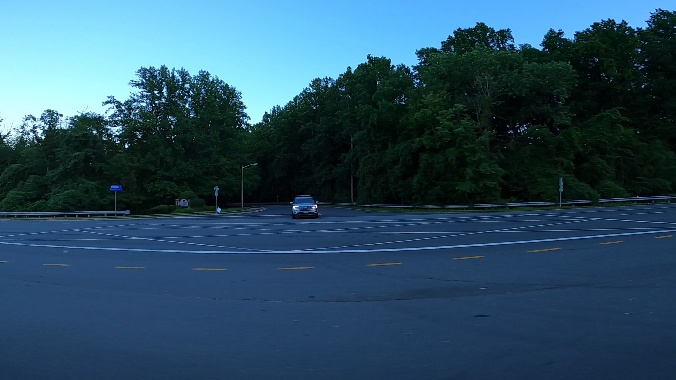

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import os
img = Image.open(os.path.join(path, labels.iloc[0]['image']))
img

In [10]:
print(os.getcwd())

/kaggle/working


In [11]:
if os.path.exists(os.getcwd() + "/custom_dataset/yolo"):
    shutil.rmtree(os.getcwd() + "/custom_dataset/yolo")

if not os.path.exists(os.getcwd() + "/custom_dataset/yolo/train"):
    os.makedirs(os.getcwd() + "/custom_dataset/yolo/train")
    
if not os.path.exists(os.getcwd() + "/custom_dataset/yolo/valid"):
    os.makedirs(os.getcwd() + "/custom_dataset/yolo/valid")
    
if not os.path.exists(os.getcwd() + "/custom_dataset/yolo/test"):
    os.makedirs(os.getcwd() + "/custom_dataset/yolo/test")    
    
if not os.path.exists(os.getcwd() + "/results"):
    os.makedirs(os.getcwd() + "/results")

In [12]:
def make_yolo_dataset(image_paths, type="train"):
    for image_path in tqdm(image_paths, total=len(image_paths)):
        source_image = cv2.imread(image_path, cv2.IMREAD_COLOR)        
        image_height, image_width, _ = source_image.shape
        
        target_image_path = f"{os.getcwd()}/custom_dataset/yolo/{type}/{os.path.basename(image_path)}"
        cv2.imwrite(target_image_path, source_image)
        
        if type == "test":
            continue
            
        yolo_labels = []
        for item in labels.itertuples():
#             print(item)
            if item[1] == image_path.split('/')[-1]:
                class_name = 0
                x_min, y_min = float(item[2]), float(item[3])
                x_max, y_max = float(item[4]), float(item[5])
                x, y = float(((x_min + x_max) / 2) / image_width), float(((y_min + y_max) / 2) / image_height)
                w, h = abs(x_max - x_min) / image_width, abs(y_max - y_min) / image_height
                yolo_labels.append(f"{class_name} {x} {y} {w} {h}")
#         print(yolo_labels)
            
        target_label_txt = f"{os.getcwd()}/custom_dataset/yolo/{type}/{os.path.basename(image_path).split('.')[0] + '.txt'}" 
        with open(target_label_txt, "w") as writer:
            for yolo_label in yolo_labels:
                writer.write(f"{yolo_label}\n")

In [13]:
image_paths = sorted(glob('/kaggle/input/car-object-detection/data/training_images/*.jpg'))

train_images_paths, valid_images_paths = train_test_split(image_paths, test_size=0.1, random_state=SEED)

make_yolo_dataset(train_images_paths, "train")
make_yolo_dataset(valid_images_paths, "valid")
make_yolo_dataset(sorted(glob('/kaggle/input/car-object-detection/data/testing_images/*.jpg')), "test")

100%|██████████| 175/175 [00:03<00:00, 57.95it/s]


In [14]:
yaml_data = {
              "names": ['car'],
              "nc": 1,
              "path": os.path.join(os.getcwd(),"custom_dataset/yolo/"),
              "train": "train",
              "val": "valid",
              "test": "test"
            }

with open(os.getcwd() + "/custom_dataset/yolo/custom.yaml", "w") as writer:
    yaml.dump(yaml_data, writer)

In [15]:
model = YOLO("yolov8x")
results = model.train(
    data= os.getcwd() + "/custom_dataset/yolo/custom.yaml",
    imgsz=(1024, 1024),
    epochs=10,
    batch=BATCH_SIZE,
    patience=5,
    workers=1,
    device=0,
    exist_ok=True,    
    project=f"{MODEL}",
    name="train",
    seed=SEED,
    pretrained=False,
    resume=False,
    optimizer="Adam",
    lr0=1e-3,
    augment=True,
    val=True,
    cache=True,
    # hsv_h=0.015,
    # hsv_s=0.7,
    # hsv_v=0.4,
    # degrees=0.25,
    # translate=0.1,
    # scale=0.5,
    # shear=20.0,
    # perspective=0.0,
    # flipud=0.5,
    # fliplr=0.5,
    # mosaic=1.0,
    # mixup=0.2,
    # copy_paste=0.2,
    )

100%|██████████| 131M/131M [00:00<00:00, 308MB/s] 
Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/working/custom_dataset/yolo/custom.yaml, epochs=10, patience=5, batch=2, imgsz=(1024, 1024), save=True, save_period=-1, cache=True, device=0, workers=1, project=v2, name=train, exist_ok=True, pretrained=False, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=True, agnostic_nms=False, clas

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 15.1MB/s]
AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
train: Scanning /kaggle/working/custom_dataset/yolo/train... 900 images, 584 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 2193.70it/s]
train: New cache created: /kaggle/working/custom_dataset/yolo/train.cache
train: Caching images (1.5GB True): 100%|██████████| 900/900 [00:07<00:00, 116.63it/s]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/custom_dataset/yolo/valid... 101 images, 62 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:0

In [16]:
def get_test_image_paths(test_image_paths):    
    for i in range(0, len(test_image_paths), BATCH_SIZE):
        yield test_image_paths[i:i+BATCH_SIZE]

In [18]:
model = YOLO(os.getcwd() + "/v2/train/weights/best.pt")
test_image_paths = glob(os.getcwd() + "/custom_dataset/yolo/test/*.jpg")
for i, image in tqdm(enumerate(get_test_image_paths(test_image_paths)), total=int(len(test_image_paths)/BATCH_SIZE)):
    model.predict(image, imgsz=(1024, 1024), iou=0.2, conf=0.5, save_conf=True, save=False, save_txt=True, project=f"{MODEL}", name="predict",
                  exist_ok=True, device=0, augment=True, verbose=False)
    if i % 5 == 0:
        clear_output(wait=True)

 99%|█████████▉| 86/87 [00:20<00:00,  4.38it/s]Results saved to v2/predict
85 labels saved to v2/predict/labels
100%|██████████| 87/87 [00:20<00:00,  4.42it/s]Results saved to v2/predict
85 labels saved to v2/predict/labels
88it [00:20,  4.22it/s]                        


In [47]:
from IPython.display import Image, display

def yolo_to_labelme(line, image_width, image_height, txt_file_name):    
    file_name = txt_file_name.split("/")[-1].replace(".txt", ".png")
    class_id, x, y, width, height, confidence = [float(temp) for temp in line.split()]
    
    x_min = int((x - width / 2) * image_width)
    x_max = int((x + width / 2) * image_width)
    y_min = int((y - height / 2) * image_height)
    y_max = int((y + height / 2) * image_height)
    
    return file_name, int(class_id), confidence, x_min, y_min, x_max, y_max

def imshow(img):
    """ndarray 배열을 인라인으로 Notebook상에 표시한다.
    """
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

  0%|          | 0/85 [00:00<?, ?it/s]

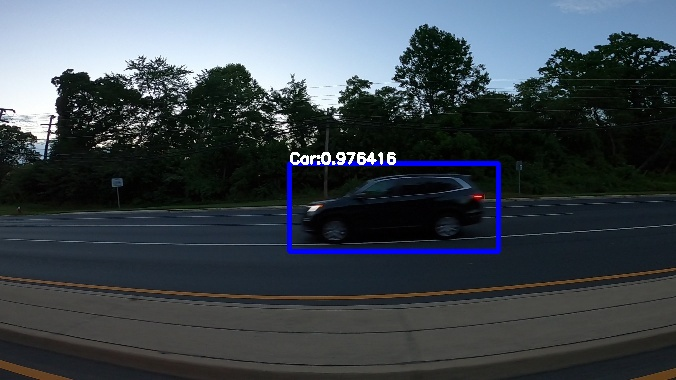

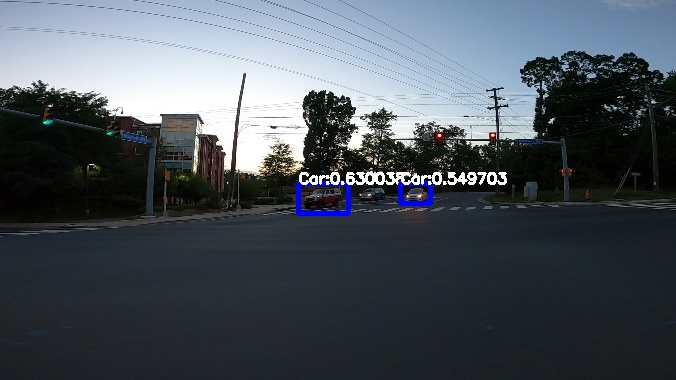

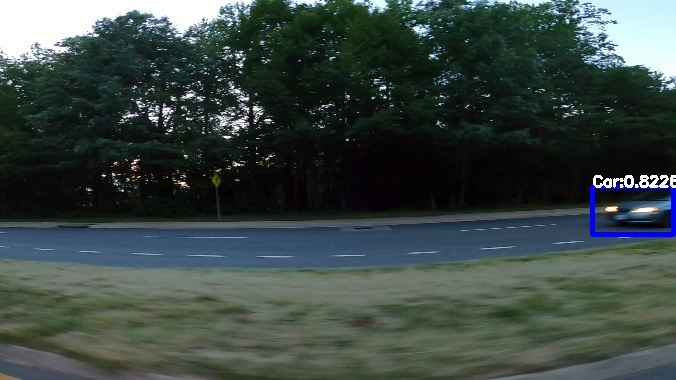

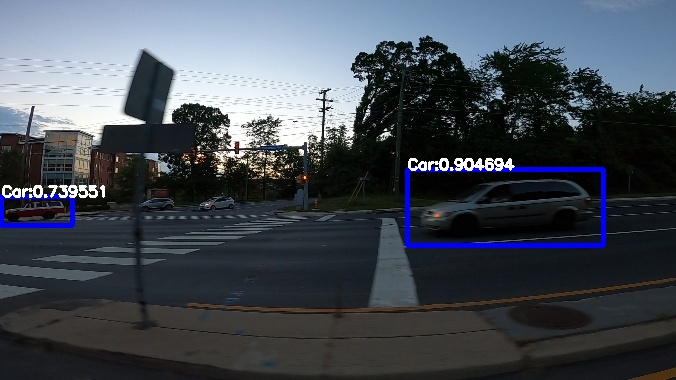

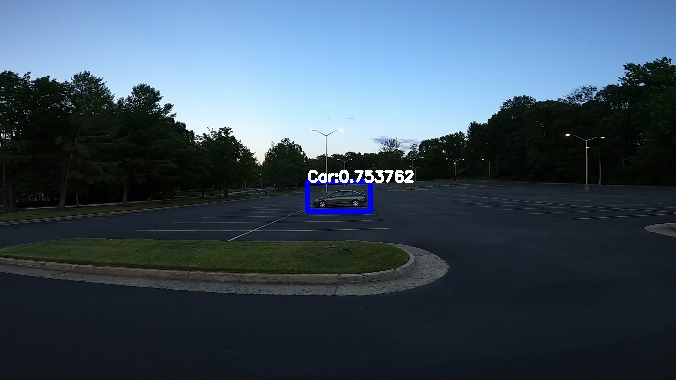

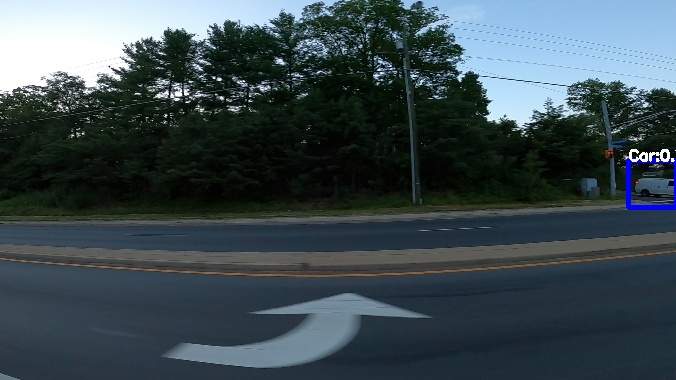

100%|██████████| 85/85 [00:00<00:00, 172.34it/s]


In [62]:
infer_txts = glob(f"{os.getcwd()}/{MODEL}/predict/labels/*.txt")
count, results = 0, []
for infer_txt in tqdm(infer_txts):
    base_file_name = infer_txt.split("/")[-1].split(".")[0]
    img = cv2.imread(f"/kaggle/input/car-object-detection/data/testing_images/{base_file_name}.jpg")   
    imgage_height, imgage_width = img.shape[:2]
    with open(infer_txt, "r") as reader:        
        lines = reader.readlines()        
        for line in lines:
            label = yolo_to_labelme(line, imgage_width, imgage_height, infer_txt)
            if count <=5:
                cv2.rectangle(img, (label[3], label[4]), (label[5], label[6]), (255, 0, 0), 3)
                cv2.putText(img, f"Car:{label[2]}", (label[3], label[4]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            results.append(label)
    if count <=5:
        imshow(img)
    count+=1
    
df_submission = pd.DataFrame(data=results, columns=["file_name", "class_id", "confidence", "x_min", "y_min", "x_max", "y_max"])
df_submission.to_csv(f"{os.getcwd()}/results/{MODEL}.csv", index=False)
    

In [64]:
sample = pd.read_csv(f"{os.getcwd()}/results/{MODEL}.csv")
sample.head()

,file_name,class_id,confidence,x_min,y_min,x_max,y_max
0,vid_5_27620.png,0,0.976416,289,163,498,251
1,vid_5_27400.png,0,0.630038,298,183,348,213
2,vid_5_27400.png,0,0.549703,400,183,430,203
3,vid_5_26560.png,0,0.822694,592,186,673,234
4,vid_5_27480.png,0,0.904694,407,169,603,245
